In [1]:
import os
import sys
import gensim
import numpy as np

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\Users\\Gosia\\Desktop\\'
sys.path.insert(0, ROOT)

In [2]:
from matchms.importing.load_from_msp import load_from_msp
spectrums = list(load_from_msp('C:\\Users\\Gosia\\Desktop\\MoNA-export-GC-MS_Spectra-msp\\MoNA-export-GC-MS_Spectra.msp'))
print(len(spectrums))

18898


In [3]:
from matchms.filtering import normalize_intensities
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import require_minimum_number_of_peaks

def apply_my_filters(s):
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = normalize_intensities(s)
    s = require_minimum_number_of_peaks(s,5)
    s = select_by_relative_intensity(s, intensity_from=0.05, intensity_to=1)
    return s

In [4]:
# apply filters to the data
spectrums_classical = [apply_my_filters(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums = [s for s in spectrums_classical if s is not None and 'inchikey' in s.metadata]

print("{} remaining spectra.".format(len(spectrums)))

18762 remaining spectra.


In [5]:
# remove duplicate peaks
specs_by_peaks = {}
for s in spectrums:
    specs_by_peaks[''.join( ('%.0f' % p) for p in sorted(s.peaks[0]))] = s

In [6]:
print(len(spectrums))
print(len(specs_by_peaks))

18762
14688


In [7]:
spectrums = list(specs_by_peaks.values())

In [8]:
inchi_dict = {}
for s in spectrums:
    ik = s.metadata.get('inchikey','')
    init_ik = ik.split('-')[0]
    if not init_ik in inchi_dict:
        inchi_dict[init_ik] = [s]
    else:
        inchi_dict[init_ik].append(s)


In [9]:
query_size = 1000

In [10]:
# choosing queries from multis ensures a possible true match
multis = set([i for i,v in inchi_dict.items() if len(v) > 1])

matching_keys = np.random.choice(list(multis), size=query_size, replace=False)

query_spec = {}
spectrums_lib = []
# We select query_size queries that have at least 1 matching spectrum in the library
for q in matching_keys:
    spec_to_add = np.random.choice(inchi_dict[q], size=1, replace=False)
    query_spec[spec_to_add[0].metadata['inchikey']] = spec_to_add[0]

# And everything else goes into the library
for s in spectrums:
    if s.metadata['inchikey'] not in query_spec or s != query_spec[s.metadata['inchikey']]:
        spectrums_lib.append(s)

spectrums_query = list(query_spec.values())

In [11]:
print(len(spectrums_query), len(spectrums_lib))

1000 13688


In [12]:
c = {}
for specs_ in inchi_dict.values():
    c.setdefault(len(specs_),0)
    c[len(specs_)] += 1
for k in sorted(c):
    print(k,c[k])

1 6686
2 1137
3 480
4 285
5 162
6 99
7 52
8 52
9 29
10 15
11 7
12 11
13 5
14 5
15 3
16 1
17 1
18 1
19 1
20 1
21 1
22 1
31 1


In [13]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

documents = [SpectrumDocument(s, n_decimals=0) for s in spectrums]


In [14]:
from spec2vec.model_building import train_new_word2vec_model

path_models = os.path.join(path_data, "trained_models")
model_file = os.path.join(path_models, "spec2vec_gcms_model_75.model")

iterations = [1, 3, 5, 10, 15, 20, 25, 30]

# Train model with default parameters
model = train_new_word2vec_model(documents, iterations, model_file, size=75)

The value of size is set from 300 (default) to 75
  Epoch 1 of 30.Change in loss after epoch 1: 118393.2578125
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_gcms_model_75_iter_1.model
  Epoch 2 of 30.Change in loss after epoch 2: 105762.6953125
  Epoch 3 of 30.Change in loss after epoch 3: 107360.171875
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_gcms_model_75_iter_3.model
  Epoch 4 of 30.Change in loss after epoch 4: 98777.0625
  Epoch 5 of 30.Change in loss after epoch 5: 100544.875
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_gcms_model_75_iter_5.model
  Epoch 6 of 30.Change in loss after epoch 6: 85669.375
  Epoch 7 of 30.Change in loss after epoch 7: 95480.375
  Epoch 8 of 30.Change in loss after epoch 8: 97423.625
  Epoch 9 of 30.Change in loss after epoch 9: 96599.3125
  Epoch 10 of 30.Change in loss after epoch 10: 95792.125
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_gcms_m

Create spectrum "documents"

In [15]:
from rdkit.Chem import MolFromSmiles, MolToSmiles
from rdkit.Chem.inchi import MolFromInchi, MolToInchi
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcMolFormula

def f(specs):
    successes = []
    for s in specs:
        mol = None
        try:
            mol = MolFromSmiles(s.get('smiles'))
        except Exception as e:
            pass
        if mol is not None:
            exact_mass_smi = CalcExactMolWt(mol)
            #print(mol,exact_mass_smi,s.get('parent_mass'))
            #if s.get('parent_mass') is None
            successes.append(s)
            s.set('very_exact_mass', exact_mass_smi)
    return successes

In [16]:
spectrums_query = f(spectrums_query)
spectrums_lib = f(spectrums_lib)

In [17]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

documents_query = [SpectrumDocument(s, n_decimals=0) for s in spectrums_query]
documents_lib = [SpectrumDocument(s, n_decimals=0) for s in spectrums_lib]
print(documents_query)

[<spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001B90695FD60>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001B90695F430>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001B90695F790>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001B90692DE50>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001B90692DB20>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001B90692DF10>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001B9069E10A0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001B9069E1100>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001B9069E1160>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001B90692D8E0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001B9069E1220>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001B9069E1070>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001B9069E12B0>, <spec2vec.SpectrumDocume

In [18]:
print(len(spectrums_query), len(spectrums_lib))

896 12683


In [19]:
from tqdm.notebook import tqdm  # optional, just to get a progress bar
from spec2vec.vector_operations import calc_vector


intensity_weighting_power = 0.5
allowed_missing_percentage = 15 # specify the maximum (weighted) fraction of the spectrum that is allowed to be missing

vector_size = model.vector_size
print(f"Embedding vector size: {vector_size}")

embeddings_spec2vec_query = np.zeros((len(documents_query), vector_size), dtype="float")
for i, doc in enumerate(tqdm(documents_query)):
    embeddings_spec2vec_query[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)
embeddings_spec2vec_lib = np.zeros((len(documents_lib), vector_size), dtype="float")
for i, doc in enumerate(tqdm(documents_lib)):
    embeddings_spec2vec_lib[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)

Embedding vector size: 75


In [20]:
intensity_weighting_power = 0.5
allowed_missing_percentage = 15
from cosine_calc import get_spec2vec_hits

hits_passatutto_true = get_spec2vec_hits( documents_query, documents_lib, metaKey='very_exact_mass', model=model, precursor_tol=1,
                                                        intensity_weighting_power=intensity_weighting_power,
                                                        allowed_missing_percentage=allowed_missing_percentage, passatutto=False, embeddings_query=embeddings_spec2vec_query, embeddings_library=embeddings_spec2vec_lib)
print(len(hits_passatutto_true))

#hits_passatutto_false = get_spec2vec_hits( documents_query, documents_lib, metaKey='very_exact_mass', model=model, precursor_tol=1,
#                                                        intensity_weighting_power=intensity_weighting_power,
#                                                        allowed_missing_percentage=allowed_missing_percentage, passatutto=False)
#
#print(len(hits_passatutto_false))


896


In [21]:
hits=hits_passatutto_true
# out of
print( len(documents_query) )
# we got this many hits
print( len( hits ))
# and out of those this many were false
print( len( [ h for h in hits if not h.hit ]))

896
896
313


In [22]:
# Calculating true q-value scores
from q_value_calc import calculate_q_value
q_list_true = calculate_q_value(hits)

In [23]:
from knockoffs import generate_knockoffs
diags = [1,2,3]

q_list_knockoffs = {}
for diag in diags:
        for comp in [2,5,7]:
                try:
                    knockoff_documents = generate_knockoffs(model,documents_lib,allowed_missing_percentage=allowed_missing_percentage,n_components=comp, diagonal_matrix=diag)

                    hits_knockoffs = get_spec2vec_hits(documents_query, knockoff_documents, decoys=True, model=model, precursor_tol=3, metaKey="very_exact_mass",
                                                                            intensity_weighting_power=intensity_weighting_power,
                                                                            allowed_missing_percentage=allowed_missing_percentage,embeddings_query=embeddings_spec2vec_query, passatutto=False)
                    q_list_knockoffs[(diag, comp)] = calculate_q_value(hits+hits_knockoffs,True)
                except Exception as e:
                    print( diag, "failed", e )
                    #raise

Embedding vector size: 75
Embedding vector size: 75
Embedding vector size: 75
Embedding vector size: 75
Embedding vector size: 75
Embedding vector size: 75
Embedding vector size: 75
Embedding vector size: 75
Embedding vector size: 75


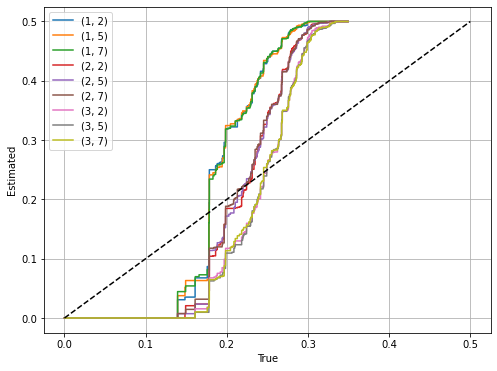

In [24]:
# plot estimated and true q-values
def combine_true_est(q_val_true,q_val_est):
    res = []
    q_idx = 0
    for q_e, _, score in q_val_est:
        while q_idx < len(q_val_true)-1 and q_val_true[q_idx+1][2] >= score:
            q_idx += 1
        res.append((score, q_val_true[q_idx][0], q_e))
    return res
        
to_plot = {}
for k,v in q_list_knockoffs.items():
    to_plot[k] = list(zip(*combine_true_est(q_list_true, v)))[1], list(zip(*combine_true_est(q_list_true, v)))[2]

import plot_q_vals
plot_q_vals.plot_q_vals( to_plot )

In [25]:
hit = [h for h in hits[:20] if not h.hit][0]

In [26]:
d = {}
d[tuple( ('%.0f' % p) for p in sorted(hit.query._obj.peaks[0]))] = 1
d[tuple( ('%.0f' % p) for p in sorted(hit.target._obj.peaks[0]))] = 2
print(d)


{('39', '46', '63', '64', '64', '65', '92', '99', '100', '127', '128', '129'): 1, ('39', '46', '63', '64', '64', '65', '91', '92', '99', '100', '127', '128', '129'): 2}


In [27]:
hit.query._obj.metadata

{'name': 'P-CHLOROANILINE',
 'synon': '$:00in-source',
 'db#': 'JP005270',
 'inchikey': 'QSNSCYSYFYORTR-UHFFFAOYSA-N',
 'spectrum_type': 'MS1',
 'instrument_type': 'EI-B',
 'instrument': 'HITACHI RMU-6M',
 'ion_mode': 'P',
 'formula': 'C6H6ClN',
 'mw': '127',
 'exactmass': '127.01887687199999',
 'smiles': 'Nc(c1)ccc(Cl)c1',
 'inchi': 'InChI=1S/C6H6ClN/c7-5-1-3-6(8)4-2-5/h1-4H,8H2',
 'computed smiles': 'C1=C(C=CC(=C1)N)Cl',
 'accession': 'JP005270',
 'date': '2016.01.19 (Created 2008.10.21, modified 2011.05.06)',
 'author': "YAMAMOTO M, DEP. CHEMISTRY, FAC. SCIENCE, NARA WOMEN'S UNIV.",
 'license': 'CC BY-NC-SA',
 'exact mass': '127.01888',
 'ionization energy': '70 eV',
 'ion type': '[M]+*',
 'splash': 'splash10-004i-7900000000-a2f8dccba0c4f29cf5f5',
 'submitter': 'University of Tokyo Team (Faculty of Engineering, University of Tokyo)',
 'mona rating': '3.75',
 'num peaks': '37',
 'very_exact_mass': 127.01887687199999}

In [28]:
hit.target._obj.metadata

{'name': 'M-CHLOROANILINE',
 'synon': '$:00in-source',
 'db#': 'JP005269',
 'inchikey': 'PNPCRKVUWYDDST-UHFFFAOYSA-N',
 'spectrum_type': 'MS1',
 'instrument_type': 'EI-B',
 'instrument': 'HITACHI RMU-6M',
 'ion_mode': 'P',
 'formula': 'C6H6ClN',
 'mw': '127',
 'exactmass': '127.01887687199999',
 'smiles': 'Nc(c1)cc(Cl)cc1',
 'inchi': 'InChI=1S/C6H6ClN/c7-5-2-1-3-6(8)4-5/h1-4H,8H2',
 'computed smiles': 'C1=CC(=CC(=C1)Cl)N',
 'accession': 'JP005269',
 'date': '2016.01.19 (Created 2008.10.21, modified 2011.05.06)',
 'author': "YAMAMOTO M, DEP. CHEMISTRY, FAC. SCIENCE, NARA WOMEN'S UNIV.",
 'license': 'CC BY-NC-SA',
 'exact mass': '127.01888',
 'ionization energy': '70 eV',
 'ion type': '[M]+*',
 'splash': 'splash10-004i-7900000000-54dad2f5a9187b00fde0',
 'submitter': 'University of Tokyo Team (Faculty of Engineering, University of Tokyo)',
 'mona rating': '3.75',
 'num peaks': '35',
 'very_exact_mass': 127.01887687199999}

In [29]:
from pprint import pprint
pprint(q_list_true)

[(0, True, 0.9929645446665658),
 (0.0, True, 0.9928971425848953),
 (0.0, True, 0.9926763057376752),
 (0.0, True, 0.9924589616148185),
 (0.08333333333333333, False, 0.9922846585824117),
 (0.08333333333333333, True, 0.9920746786121585),
 (0.08333333333333333, True, 0.9920352750564096),
 (0.08333333333333333, True, 0.9914983003134076),
 (0.08333333333333333, True, 0.9905861898289545),
 (0.08333333333333333, True, 0.9902442863543554),
 (0.08333333333333333, True, 0.9901854142897187),
 (0.08333333333333333, True, 0.9899198123969042),
 (0.11764705882352941, False, 0.9899102014048589),
 (0.11764705882352941, True, 0.9899004712974255),
 (0.11764705882352941, True, 0.9898503337064118),
 (0.11764705882352941, True, 0.9896236746573492),
 (0.11764705882352941, True, 0.9894549758960118),
 (0.13934426229508196, False, 0.9888566199540509),
 (0.13934426229508196, True, 0.9886279205887616),
 (0.13934426229508196, False, 0.9883280789755375),
 (0.13934426229508196, True, 0.9881113300855946),
 (0.13934426

In [30]:
pprint(q_list_knockoffs)

{(1, 2): [(0, True, 0.9929645446665658),
          (0.0, True, 0.9928971425848953),
          (0.0, True, 0.9926763057376752),
          (0.0, True, 0.9924589616148185),
          (0.0, False, 0.9922846585824117),
          (0.0, True, 0.9920746786121585),
          (0.0, True, 0.9920352750564096),
          (0.0, True, 0.9914983003134076),
          (0.0, True, 0.9905861898289545),
          (0.0, True, 0.9902442863543554),
          (0.0, True, 0.9901854142897187),
          (0.0, True, 0.9899198123969042),
          (0.0, False, 0.9899102014048589),
          (0.0, True, 0.9899004712974255),
          (0.0, True, 0.9898503337064118),
          (0.0, True, 0.9896236746573492),
          (0.0, True, 0.9894549758960118),
          (0.0, False, 0.9888566199540509),
          (0.0, True, 0.9886279205887616),
          (0.0, False, 0.9883280789755375),
          (0.0, True, 0.9881113300855946),
          (0.0, False, 0.9880077839568295),
          (0.0, True, 0.9879713967446848),
        

          (0.27346938775510204, False, 0.9220095495166802),
          (0.27346938775510204, True, 0.921955219449608),
          (0.27346938775510204, 'decoy', 0.9219471806574862),
          (0.27346938775510204, False, 0.9219243705055807),
          (0.27346938775510204, True, 0.9218921237424849),
          (0.27346938775510204, False, 0.921838381558511),
          (0.27346938775510204, True, 0.9217493193203157),
          (0.27494908350305497, 'decoy', 0.9217348995847621),
          (0.27586206896551724, 'decoy', 0.9215432433586652),
          (0.27586206896551724, True, 0.9215180665786411),
          (0.2767676767676768, 'decoy', 0.9211074977805027),
          (0.2767676767676768, True, 0.921081696009794),
          (0.2782258064516129, 'decoy', 0.9208981841446661),
          (0.2796780684104628, 'decoy', 0.9207177334084307),
          (0.2803180914512923, 'decoy', 0.9204759939336087),
          (0.2803180914512923, 'decoy', 0.9199152341003607),
          (0.2803180914512923, True, 0

 (1, 5): [(0, True, 0.9929645446665658),
          (0.0, True, 0.9928971425848953),
          (0.0, True, 0.9926763057376752),
          (0.0, True, 0.9924589616148185),
          (0.0, False, 0.9922846585824117),
          (0.0, True, 0.9920746786121585),
          (0.0, True, 0.9920352750564096),
          (0.0, True, 0.9914983003134076),
          (0.0, True, 0.9905861898289545),
          (0.0, True, 0.9902442863543554),
          (0.0, True, 0.9901854142897187),
          (0.0, True, 0.9899198123969042),
          (0.0, False, 0.9899102014048589),
          (0.0, True, 0.9899004712974255),
          (0.0, True, 0.9898503337064118),
          (0.0, True, 0.9896236746573492),
          (0.0, True, 0.9894549758960118),
          (0.0, False, 0.9888566199540509),
          (0.0, True, 0.9886279205887616),
          (0.0, False, 0.9883280789755375),
          (0.0, True, 0.9881113300855946),
          (0.0, False, 0.9880077839568295),
          (0.0, True, 0.9879713967446848),
        

          (0.4921821889870836, 'decoy', 0.6849731937392155),
          (0.4921821889870836, 'decoy', 0.6847758827097237),
          (0.4921821889870836, True, 0.684764055981717),
          (0.4921821889870836, 'decoy', 0.6845819462760179),
          (0.4921821889870836, 'decoy', 0.6845679172855097),
          (0.4921821889870836, True, 0.683517791440465),
          (0.4921821889870836, False, 0.6830706934342239),
          (0.4921821889870836, False, 0.6827314647296525),
          (0.4921821889870836, True, 0.681623999963142),
          (0.4921821889870836, 'decoy', 0.6816169767654494),
          (0.4921821889870836, True, 0.6814144513716806),
          (0.4921821889870836, 'decoy', 0.6806742118667686),
          (0.4921821889870836, True, 0.6805519203059349),
          (0.4921821889870836, True, 0.6804220226557525),
          (0.4922033898305085, 'decoy', 0.6792104841881546),
          (0.4922033898305085, 'decoy', 0.6790362790963439),
          (0.4922033898305085, False, 0.679028142

          (0.40611353711790393, False, 0.8518352969796212),
          (0.40676117775354415, 'decoy', 0.8516217808118808),
          (0.4074074074074074, 'decoy', 0.8514581448759369),
          (0.4076086956521739, 'decoy', 0.8513415289815061),
          (0.4076086956521739, False, 0.851300466748768),
          (0.4078091106290672, 'decoy', 0.8508208604366121),
          (0.4078091106290672, True, 0.8507269225717509),
          (0.408008658008658, 'decoy', 0.8506821889649792),
          (0.408008658008658, False, 0.8506159667807183),
          (0.40864864864864864, 'decoy', 0.8506136584280306),
          (0.40904198062432723, 'decoy', 0.8504068207646478),
          (0.40904198062432723, 'decoy', 0.8501729207090454),
          (0.40904198062432723, True, 0.8501324493778191),
          (0.40904198062432723, False, 0.8499599633608221),
          (0.4096774193548387, 'decoy', 0.8497983974485515),
          (0.410010649627263, 'decoy', 0.849031017962551),
          (0.410010649627263, 'decoy

          (0.12658227848101267, True, 0.9250325499535914),
          (0.12658227848101267, True, 0.9248536950226172),
          (0.12658227848101267, False, 0.9245886487680499),
          (0.12814070351758794, 'decoy', 0.9237520484669199),
          (0.12814070351758794, False, 0.9232436873284555),
          (0.12814070351758794, True, 0.9232002920440596),
          (0.13, 'decoy', 0.9231759442505212),
          (0.13, True, 0.9230484624023755),
          (0.13216957605985039, 'decoy', 0.9228977708896458),
          (0.13333333333333333, 'decoy', 0.9225792403794657),
          (0.13333333333333333, True, 0.9224270220324775),
          (0.13333333333333333, False, 0.9221565694772866),
          (0.13333333333333333, False, 0.9220095495166802),
          (0.13349514563106796, 'decoy', 0.9220093692590889),
          (0.13349514563106796, True, 0.921955219449608),
          (0.13349514563106796, False, 0.9219243705055807),
          (0.13349514563106796, True, 0.9218921237424849),
        

          (0.01694915254237288, True, 0.9649625219600393),
          (0.01694915254237288, True, 0.9648834181685201),
          (0.01694915254237288, True, 0.9639062233036408),
          (0.01694915254237288, True, 0.9634862403870716),
          (0.01694915254237288, True, 0.9634748489143181),
          (0.01694915254237288, True, 0.9629636920891939),
          (0.01694915254237288, True, 0.9629431712080843),
          (0.01694915254237288, True, 0.9628103744420867),
          (0.022099447513812154, 'decoy', 0.9625079325363606),
          (0.022099447513812154, False, 0.9623487533475479),
          (0.022099447513812154, True, 0.9621254863169044),
          (0.022099447513812154, True, 0.9617952737706454),
          (0.02336448598130841, 'decoy', 0.9616416189408807),
          (0.02336448598130841, True, 0.9614175784705441),
          (0.02336448598130841, True, 0.9614047692393058),
          (0.02336448598130841, True, 0.9613725451250046),
          (0.02336448598130841, False, 0.9613

          (0.49595519601742377, 'decoy', 0.5623128673073869),
          (0.49595519601742377, False, 0.5621903262041049),
          (0.49595519601742377, True, 0.5614845735383884),
          (0.49595519601742377, False, 0.5588511203903994),
          (0.49595519601742377, 'decoy', 0.5585682852838858),
          (0.49595519601742377, True, 0.5584054133091231),
          (0.49595519601742377, False, 0.5576694931473134),
          (0.4959602237414543, 'decoy', 0.5572406915700077),
          (0.4959602237414543, False, 0.5552653623422512),
          (0.4962732919254658, 'decoy', 0.554675379522312),
          (0.4962871287128713, 'decoy', 0.5544684743780967),
          (0.4962871287128713, 'decoy', 0.5540955783221502),
          (0.4962871287128713, False, 0.5535580824284991),
          (0.4962871287128713, 'decoy', 0.550954704930207),
          (0.4962871287128713, False, 0.5501482507222965),
          (0.4962871287128713, True, 0.5500316664237972),
          (0.496291718170581, 'decoy', 0

          (0.4499618029029794, 'decoy', 0.7108550210553508),
          (0.4499618029029794, False, 0.7108215326529842),
          (0.4500381388253242, 'decoy', 0.7106855060876534),
          (0.4500381388253242, True, 0.7099808164905494),
          (0.4504573170731707, 'decoy', 0.7096023673912127),
          (0.45087585681645087, 'decoy', 0.7091365996596688),
          (0.4512937595129376, 'decoy', 0.7090886596473189),
          (0.4513677811550152, 'decoy', 0.7090761409478834),
          (0.4513677811550152, False, 0.7088889600064399),
          (0.4517843583902809, 'decoy', 0.707724378579605),
          (0.4518574677786202, 'decoy', 0.707635075168713),
          (0.4518574677786202, False, 0.7073397834960167),
          (0.45227272727272727, 'decoy', 0.7064775191469915),
          (0.45268735806207416, 'decoy', 0.706114755442328),
          (0.4527588813303099, 'decoy', 0.7058555867908443),
          (0.4527588813303099, True, 0.7051079880994886),
          (0.45317220543806647, 'dec

          (0.2651331719128329, True, 0.8153653299333641),
          (0.2651331719128329, True, 0.8142410161746577),
          (0.26570048309178745, 'decoy', 0.8138385995571011),
          (0.26570048309178745, False, 0.8137441313936706),
          (0.26626506024096386, 'decoy', 0.8136634371929616),
          (0.26626506024096386, True, 0.8133932725610734),
          (0.2665066026410564, 'decoy', 0.8133856519070699),
          (0.2665066026410564, False, 0.8131144799613905),
          (0.2665066026410564, False, 0.8130276262515438),
          (0.2673860911270983, 'decoy', 0.8122877633604085),
          (0.2682634730538922, 'decoy', 0.8122091953572619),
          (0.26913875598086123, 'decoy', 0.811726011869392),
          (0.27001194743130225, 'decoy', 0.8116280970732412),
          (0.27088305489260145, 'decoy', 0.8114622586025699),
          (0.27175208581644816, 'decoy', 0.8113087027062886),
          (0.2726190476190476, 'decoy', 0.8104149813410049),
          (0.2734839476813318, '

          (0.16638655462184873, True, 0.8766404452463854),
          (0.16638655462184873, False, 0.8762136313094627),
          (0.16638655462184873, False, 0.8758643541979306),
          (0.16778523489932887, 'decoy', 0.875099502392013),
          (0.16833333333333333, 'decoy', 0.8750754955640581),
          (0.16833333333333333, True, 0.8747688191368075),
          (0.16833333333333333, True, 0.8746690708657556),
          (0.16833333333333333, True, 0.8746452533273995),
          (0.16943521594684385, 'decoy', 0.874376115005945),
          (0.16943521594684385, True, 0.8742503110442876),
          (0.17081260364842454, 'decoy', 0.873976379002412),
          (0.17218543046357615, 'decoy', 0.8739153054416162),
          (0.17326732673267325, 'decoy', 0.8731172431024352),
          (0.17326732673267325, True, 0.8727146438879513),
          (0.1734860883797054, 'decoy', 0.8726663775193355),
          (0.1734860883797054, True, 0.8726024804350956),
          (0.1734860883797054, True, 0

          (0.03, False, 0.9412041563048437),
          (0.03, True, 0.9411683423079928),
          (0.03, True, 0.9409456585332348),
          (0.033112582781456956, 'decoy', 0.940671767668179),
          (0.033112582781456956, True, 0.9406536084431342),
          (0.036303630363036306, 'decoy', 0.9406230214106404),
          (0.03908794788273615, 'decoy', 0.9401115779258612),
          (0.03908794788273615, True, 0.9398709115112571),
          (0.03908794788273615, True, 0.939529188517207),
          (0.03908794788273615, False, 0.9393612154660841),
          (0.04180064308681672, 'decoy', 0.9391271264566681),
          (0.04180064308681672, True, 0.9385909974913929),
          (0.04180064308681672, True, 0.9383665598090891),
          (0.04180064308681672, True, 0.9383128361356015),
          (0.0438871473354232, 'decoy', 0.9382013103723787),
          (0.0438871473354232, True, 0.9380146475668989),
          (0.0438871473354232, True, 0.9378796029816432),
          (0.04388714733542

In [40]:
totals = {}
for k in to_plot:
    totals[k] = 0 
    for tru,est in zip(*to_plot[k]):
        totals[k] += abs(tru-est)

In [41]:
totals

{(1, 2): 258.7076952230795,
 (1, 5): 259.4887332313879,
 (1, 7): 258.23522236605515,
 (2, 2): 207.2946902155316,
 (2, 5): 205.05688067449083,
 (2, 7): 204.60162531375326,
 (3, 2): 195.16016339706687,
 (3, 5): 195.3478580837841,
 (3, 7): 193.93847073108094}